# <font color='aqua'> In this notebook, we'll be using Last Journey to compute Power Spectra, then build up into Bispectra stuff. </font>

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import healpy as hp
from astropy.constants import c
from astropy.units import u
from scipy import stats
from scipy.integrate import romberg
import pyccl as ccl
import math
from tqdm.notebook import tqdm
import pickle

from helper_funcs import *

In [3]:
# mask_apo0 = "masks/galactic_plane_masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits"
# mask_apo2 = "masks/galactic_plane_masks/HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
# mask_apo5 = "masks/galactic_plane_masks/HFI_Mask_GalPlane-apo5_2048_R2.00.fits"

#### <font color='aqua'> Let's try Patricia/Michael's light cone from Last Journey </font>

First let's read the binary file, change it into RING-ordering, downsize it, then write it as a FITs file.

In [4]:
# # Reading the map
# lj_nmap = np.fromfile("maps/lj_density_map_247_dens.bin", dtype='<f')

# # Reorder from nested scheme to ring scheme
# lj_rmap = hp.reorder(lj_nmap, n2r = True)

# # print npix,nside before downgrading
# print("npix before dg:",hp.get_nside(lj_rmap),"| nside before dg:",hp.get_map_size(lj_rmap))

# # Downsize it
# lj_dg = hp.ud_grade(lj_rmap, nside_out=2048, order_out='RING')

# # print npix,nside after downgrading
# print("npix after dg:",hp.get_nside(lj_dg),"| nside after dg:",hp.get_map_size(lj_dg))

# np.save("maps/lj_density_map_247_dens.npy", lj_dg)
# print("saved successfully!")

#### <font color='aqua'> All loaded, now let's use it! </font>

In [5]:
# loading the map back in

lj_map = np.load("maps/lj_density_map_247_dens.npy")

#### <font color='aqua'> Let's take a look at the map </font>

0.0 180.0 -180.0 180.0


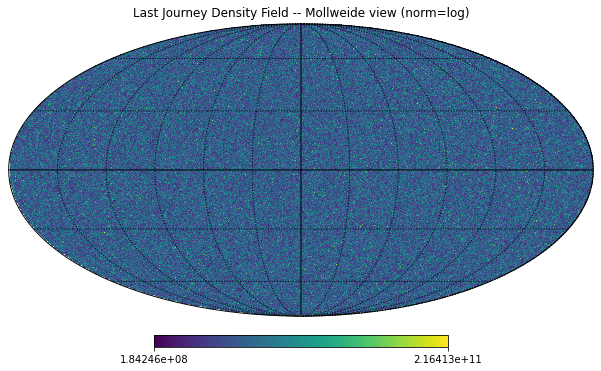

In [6]:
hp.mollview(lj_map, title="Last Journey Density Field -- Mollweide view (norm=log)", norm='log')
hp.graticule()

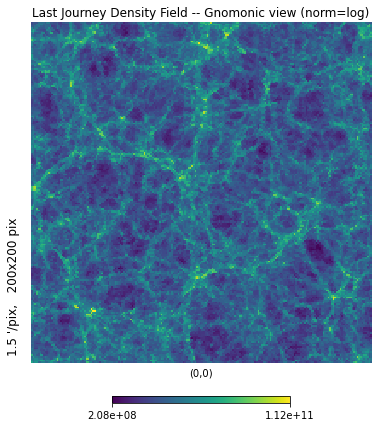

In [7]:
hp.gnomview(lj_map, title="Last Journey Density Field -- Gnomonic view (norm=log)", norm='log')

### <font color='aqua'> Time for some Power Spectrum stuff </font>

#### <font color='aqua'> First we need to find the Angular Power Spectrum </font>

In [8]:
nside_lj = hp.get_nside(lj_map)

pix_area = hp.nside2pixarea(nside_lj)

print("Pixel Area:",pix_area)

Pixel Area: 2.4967135219492856e-07


In [9]:
# find_stats(lj_map, hp_map=True)a

In [10]:
# overdensity delta = (rho-rhobar)/rhobar = rho/rhobar - 1

# rough estimate for the overdensity

del_approx = lj_map / np.mean(lj_map) - 1

# more precise estimate for the overdensity

del_prec = lj_map*pix_area / np.mean(lj_map*pix_area) - 1

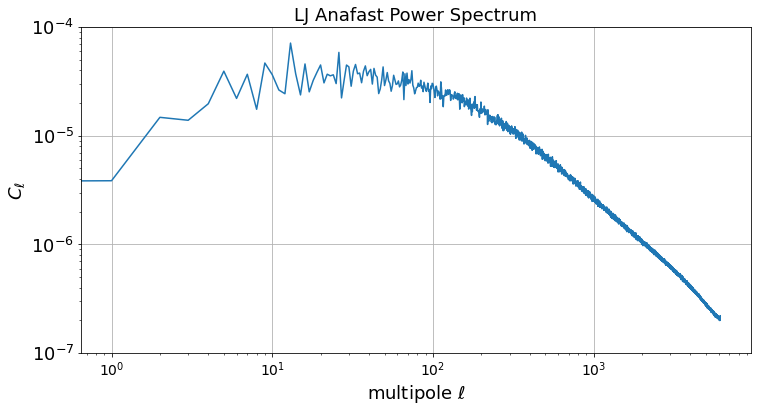

In [11]:
# approx

# cl = hp.anafast(del_approx)

# cl_pickle_out = open("lj_cl_anafast.pickle","wb")
# pickle.dump(cl, cl_pickle_out)
# cl_pickle_out.close()

cl_pickle_in = open("lj_cl_anafast.pickle","rb")
cl = pickle.load(cl_pickle_in)

ell = np.arange(len(cl))

plot_cl(ell, cl, ylim=(1e-7,1e-4), title="LJ Anafast Power Spectrum")

#### <font color='aqua'> Now let's compute the $C_{\ell}$'s from the $a_{{\ell}m}$'s analytically </font>

In [12]:
# # alms = hp.map2alm(del_approx)

# # alms_pickle_out = open("lj_map2alms.pickle","wb")
# # pickle.dump(alms, alms_pickle_out)
# # alms_pickle_out.close()

alms_pickle_in = open("lj_map2alms.pickle","rb")
alms = pickle.load(alms_pickle_in)

In [13]:
# lets confirm the sizes

lmax = len(cl)

num_ms = 0

for l in range(lmax+1):
    ms = np.arange(0,l,1)
    num_ms += len(ms)

print("number of ell's + m's: {}\nnumber of a_lm's: {}".format(num_ms,len(alms)))

if num_ms == len(alms):
    print("values agree, success!")
else:
    print("values do not agree")

number of ell's + m's: 18877440
number of a_lm's: 18877440
values agree, success!


In [14]:
# sorted_alms = sort_alms(alms, len(cl))

# sorted_alms_pickle_out = open("lj_sorted_alms.pickle","wb")
# pickle.dump(sorted_alms, sorted_alms_pickle_out)
# sorted_alms_pickle_out.close()

sorted_alms_pickle_in = open("lj_sorted_alms.pickle","rb")
sorted_alms = pickle.load(sorted_alms_pickle_in)

In [15]:
computed_cls = compute_cls(sorted_alms)
ells = np.arange(0,len(computed_cls),1)

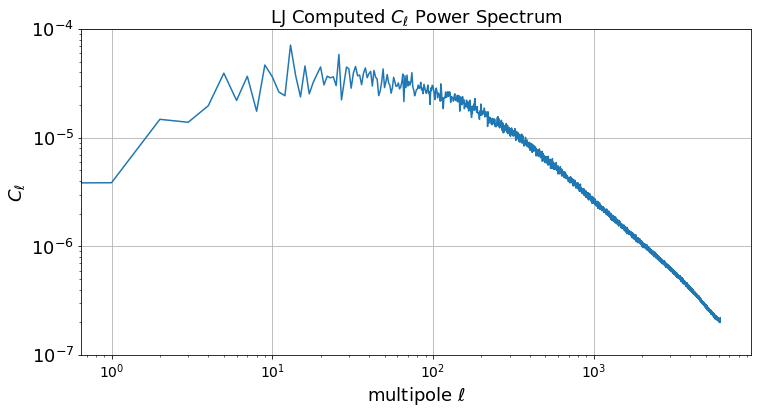

In [16]:
plot_cl(ells, computed_cls, ylim=(1e-7,1e-4), title="LJ Computed $C_{\ell}$ Power Spectrum")

#### <font color='aqua'> Now let's try computing $C_{\ell}$ from $P(k)$ with $z=1$ and Planck 2018 parameters. </font>

In [17]:
# Using Planck 2018 parameters

cosmo = ccl.Cosmology(Omega_c=0.26067, Omega_b=0.049,
                            h=0.6766, n_s=0.9665, sigma8=0.8102,
                            transfer_function='boltzmann_camb')

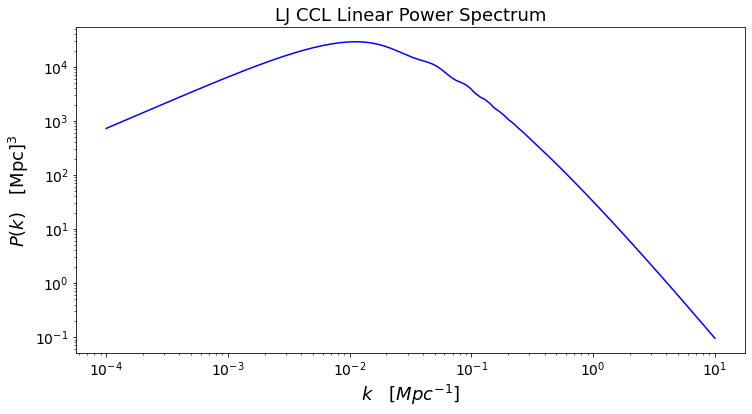

In [18]:
kmin, kmax, nk = 1e-4, 1e1, 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
z = 1 # redshift
a = 1 / (1 + z) # scale factor at z=z

pk_lin = ccl.linear_matter_power(cosmo, k, a)

plot_pk(k, pk_lin, title="LJ CCL Linear Power Spectrum")

Equation for finding $C_{\ell}$ from $P(k)$ assuming we're $\textit{not}$ dealing with a finite spherical thin shell:

$$ C_{\ell} = \frac{2}{\pi}\int_0^{\infty} dk\cdot k^2\cdot P(k)\cdot \left|\frac{\Theta_{\ell}(k)}{\delta(k)}\right |^2 $$

However, note that Last Journey is already an overdensity plot, implying that $\Theta_{\ell}(k)=\delta(k)$, so:

$$ \left| \frac{\Theta_{\ell}(k)}{\delta(k)}\right |^2 = \left|\frac{\delta(k)}{\delta(k)}\right |^2 = 1 $$

Implying that, for the ideal case, we find:

$$ C_{\ell} = \frac{2}{\pi}\int_0^{\infty} dk\cdot k^2\cdot P(k) $$

Now, when we're dealing with a finite spherical thin shell, as is the case for the Last Journey density map we've been using, we have to amend our previous equation with a $\texttt{sinc}$ correction factor. Namely, this gives us:

$$ \boxed{C_{\ell}^{\text{shell}} = \frac1{r^2} \int \frac{dk_{\parallel}}{2\pi}\cdot P_{\delta}(k)\cdot \rm{sinc}\left(\frac{k_{\parallel}\Delta r}{2}\right)} \tag{\text{finite}} $$

such that $k = (k_{\parallel}^2 + |\mathbf{k}_{\perp}|^2)^{1/2}$, where $\mathbf{k}_{\perp} = \ell/r$.

However, in the case of the infinite shell, we can just take the limit as $k_{\parallel}\Delta r\to\infty$ of the thin spherical shell, which would give us:

$$ \boxed{\lim_{k_{\parallel}\delta r\to\infty} C_{\ell}^{\text{shell}} = \frac{1}{r^2\Delta r} P_{\delta}\left(k=\frac{\ell}{r}\right)} \tag{\text{infinite}} $$

In [19]:
z = 1.
dcm = ccl.comoving_radial_distance(cosmo, 1/(1+z)) # Mpc

def compute_lj_scale_factor(step):
    return 1/201 + (1-1/201)/500 * (step+1) # formula from Michael

# scale factor + comoving distance for step=246

a247 = compute_lj_scale_factor(247)
dcm = ccl.comoving_radial_distance(cosmo, a247) # Mpc
print("Comoving Radial Distance: {:.4f} Mpc".format(dcm))

# scale factor + comoving distance for step=248

a248 = compute_lj_scale_factor(248)
dcm248 = ccl.comoving_radial_distance(cosmo, a248) # Mpc

delta_r = dcm - dcm248
print("Width of Shell: {:.4f} Mpc".format(delta_r))

Comoving Radial Distance: 3413.2489 Mpc
Width of Shell: 19.8293 Mpc


In [20]:
def _cl_shell(k_par, k_perp, r, delta_r, a):
    pk = ccl.linear_matter_power(cosmo, np.sqrt(k_perp**2 + k_par**2), a)
    return 1/(r**2) * 1/(2*np.pi) * pk * np.sinc((k_par*delta_r)/2)

def pk2cls(ells, r, delta_r, a, finite=True, kmin=1e-3, kmax=2., rtol=1e-6):
    '''
    Function that finds the variance C_l's given an input power spectrum P(k), depending
    on finite vs infinite spherical shell. If finite, uses romberg integration and finite thin shell
    equation; if infinite, uses the limit as k_par * delta r --> infinity.

    Parameters
    -----------
    ells : l-modes
    r : comoving radial distance of shell
    delta_r : radial width of shell
    a : scale factor
    finite : defaults to true, uses finite thin shell equation; if false, uses infinite shell equation
    kmin : [thin shell case] lower k-bound for integration
    kmax : [thin shell case] upper k-bound for integration
    rtol : [thin shell case] relative error tolerance

    Returns
    -----------
    cls : numpy array containing the C_l's
    '''
    cls = np.zeros_like(ells, dtype='float')

    for l in ells:
        k_perp = l/r
        if finite:
            args = [k_perp, r, delta_r, a]
            cls[l] = romberg(_cl_shell, kmin, kmax, args, rtol=rtol)
        else:
            cls[l] = 1/(r**2 * delta_r) * ccl.linear_matter_power(cosmo, k_perp, a)
    
    return cls

In [21]:
# cls_from_pk_finite = pk2cls(ells, dcm, delta_r, a247)

# cls_from_pk_finite_pickle_out = open("lj_cls_from_pk_finite.pickle","wb")
# pickle.dump(cls_from_pk_finite, cls_from_pk_finite_pickle_out)
# cls_from_pk_finite_pickle_out.close()

cls_from_pk_finite_pickle_in = open("lj_cls_from_pk_finite.pickle","rb")
cls_from_pk_finite = pickle.load(cls_from_pk_finite_pickle_in)

# cls_from_pk_infinite = pk2cls(ells, dcm, delta_r, a247, finite=False)

# cls_from_pk_infinite_pickle_out = open("lj_cls_from_pk_infinite.pickle","wb")
# pickle.dump(cls_from_pk_infinite, cls_from_pk_infinite_pickle_out)
# cls_from_pk_infinite_pickle_out.close()

cls_from_pk_infinite_pickle_in = open("lj_cls_from_pk_infinite.pickle","rb")
cls_from_pk_infinite = pickle.load(cls_from_pk_infinite_pickle_in)

In [22]:
def overplot_cls(ell, cl_anafast, cl_computed, cl_measured_finite, cl_measured_infinite, figsize=(12, 6), xscale='log', 
                    yscale='log', xlabel="multipole $\ell$", ylabel="$C_{\ell}$", 
                    ylim=[1e-8,1e-3], title="Power Spectrum"):
    plt.figure(figsize=figsize)
    plt.plot(ell, cl_anafast, c='cornflowerblue', label="Anafast $C_{\ell}$")
    plt.plot(ell, cl_computed, c='m', label="Computed $C_{\ell}$")
    plt.plot(ell, cl_measured_finite, c='red', linestyle='dashed', label=r"$C_{\ell}$ from $P(k)$ (finite)")
    plt.plot(ell, cl_measured_infinite, c='blue', linestyle='dotted', label=r"$C_{\ell}$ from $P(k)$ (infinite)")
    plt.ylabel(ylabel, fontsize=18)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.ylim(ylim)
    plt.xlabel(xlabel, fontsize=18)
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=18)

    plt.legend(frameon=False, loc='upper right', fontsize=14)
    plt.grid()

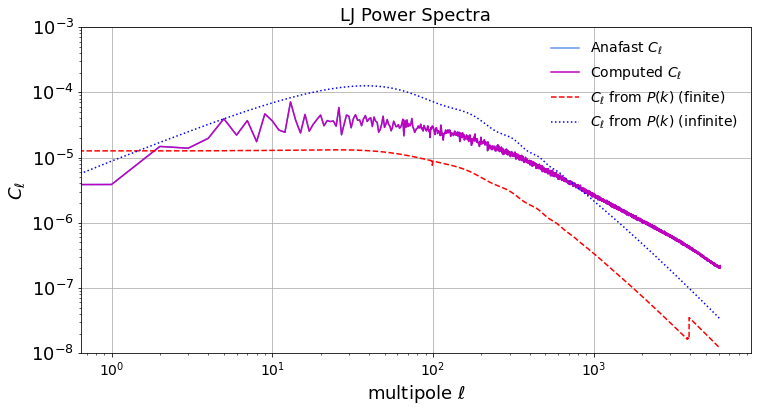

In [23]:
overplot_cls(ells, cl, computed_cls, cls_from_pk_finite, cls_from_pk_infinite, title="LJ Power Spectra")

## <font color='aqua'> Time for Bispectra! </font>

To compute the bispectrum for Last Journey, we have the following equation for the binned bispectrum estimator (excluding polarization factors because we're dealing with a scalar temperature field):

$$ B_{\ell_1\ell_2\ell_3} = \sqrt{N_{\Delta}^{\ell_1\ell_2\ell_3}} \sum_{m_1,m_2,m_3} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    m_1 & m_2 & m_3
\end{pmatrix} \langle a_{\ell_1 m_1} a_{\ell_2 m_2} a_{\ell_3 m_3} \rangle $$

such that:

$$ N_{\Delta}^{\ell_1\ell_2\ell_3} = \frac{(2\ell_1+1)(2\ell_2+1)(2\ell_3+1)}{4\pi} \begin{pmatrix}
    \ell_1 & \ell_2 & \ell_3 \\
    0 & 0 & 0
\end{pmatrix}^2

In [24]:
import numba as nb
import sympy
import spherical
import numba_progress

from spherical import Wigner3j
from sympy.physics.wigner import wigner_3j
from numba import jit, njit, prange, set_num_threads
from numba_progress import ProgressBar
import pywigxjpf as wig

In [25]:
# pywigxjpf
def get_w3j(j1, j2, j3, m1, m2, m3):
    return wig.wig3jj(2*j1, 2*j2, 2*j3, 2*m1, 2*m2, 2*m3)

def compute_bispec(l1, l2, l3, alms_l1, alms_l2, alms_l3):

    assert (l1 + l2 + l3) % 2 == 0, "even parity not satisfied" # even parity
    assert np.abs(l1-l2) <= l3, "LHS of triangle inequality not satisfied" # triangle inequality LHS
    assert l3 <= l1+l2, "RHS of triangle inequality not satisfied" # triangle inequality RHS

    bispec_sum = 0

    alms_l1, alms_l2, alms_l3 = np.abs(alms_l1), np.abs(alms_l2), np.abs(alms_l3)

    for m1 in range(-l1, l1+1):
        for m2 in range(-l2, l2+1):
            m3 = -(m1 + m2) # condition that m1 + m2 + m3 == 0 fully determines m3
            w3j = Wigner3j(l1, l2, l3, m1, m2, m3)
            if w3j != 0:
                exp_alms = alms_l1[m1] * alms_l2[m2] * alms_l3[m3]
                bispec_sum += np.abs(w3j) * exp_alms

    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) * (Wigner3j(l1, l2, l3, 0, 0, 0))**2

    return np.sqrt(norm_factor) * bispec_sum

@njit(parallel=True)
def compute_bispec_jit(l1, l2, l3, alms_l1, alms_l2, alms_l3, num_threads=16):

    set_num_threads(num_threads)

    assert (l1 + l2 + l3) % 2 == 0, "even parity not satisfied" # even parity
    assert np.abs(l1-l2) <= l3, "LHS of triangle inequality not satisfied" # triangle inequality LHS
    assert l3 <= l1+l2, "RHS of triangle inequality not satisfied" # triangle inequality RHS

    bispec_sum = 0

    alms_l1, alms_l2, alms_l3 = np.abs(alms_l1), np.abs(alms_l2), np.abs(alms_l3)

    for m1 in prange(-l1, l1+1):
        for m2 in range(-l2, l2+1):
            m3 = -(m1 + m2) # condition that m1 + m2 + m3 == 0 fully determines m3
            w3j = Wigner3j(l1, l2, l3, m1, m2, m3)
            if w3j != 0:
                exp_alms = alms_l1[m1] * alms_l2[m2] * alms_l3[m3]
                bispec_sum += np.abs(w3j) * exp_alms
    
    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) * (Wigner3j(l1, l2, l3, 0, 0, 0))**2

    return np.sqrt(norm_factor) * bispec_sum

def compute_bispec_test(l1, l2, l3, alms_l1, alms_l2, alms_l3):

    assert (l1 + l2 + l3) % 2 == 0, "even parity not satisfied" # even parity
    assert np.abs(l1-l2) <= l3, "LHS of triangle inequality not satisfied" # triangle inequality LHS
    assert l3 <= l1+l2, "RHS of triangle inequality not satisfied" # triangle inequality RHS

    # wig.wig_table_init(2*max(l1, l2, l3), 3)
    # wig.wig_temp_init(2*max(l1, l2, l3))

    bispec_sum = 0

    alms_l1, alms_l2, alms_l3 = np.abs(alms_l1), np.abs(alms_l2), np.abs(alms_l3)

    for m1 in tqdm(range(-l1, l1+1)):
        for m2 in range(-l2, l2+1):
            m3 = -(m1 + m2) # condition that m1 + m2 + m3 == 0 fully determines m3
            w3j = get_w3j(l1, l2, l3, m1, m2, m3)
            if w3j != 0:
                exp_alms = alms_l1[m1] * alms_l2[m2] * alms_l3[m3]
                bispec_sum += np.abs(w3j) * exp_alms

    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) * (get_w3j(l1, l2, l3, 0, 0, 0))**2

    return np.sqrt(norm_factor) * bispec_sum

@njit(parallel=True, nogil=True)
def compute_bispec_jit_test(l1, l2, l3, alms_l1, alms_l2, alms_l3, progress_proxy, num_threads=16):

    set_num_threads(num_threads)

    assert (l1 + l2 + l3) % 2 == 0, "even parity not satisfied" # even parity
    assert np.abs(l1-l2) <= l3, "LHS of triangle inequality not satisfied" # triangle inequality LHS
    assert l3 <= l1+l2, "RHS of triangle inequality not satisfied" # triangle inequality RHS

    bispec_sum = 0

    alms_l1, alms_l2, alms_l3 = np.abs(alms_l1), np.abs(alms_l2), np.abs(alms_l3)

    for m1 in prange(-l1, l1+1):
        for m2 in range(-l2, l2+1):
            m3 = -(m1 + m2) # condition that m1 + m2 + m3 == 0 fully determines m3
            w3j = Wigner3j(l1, l2, l3, m1, m2, m3)
            if w3j != 0:
                exp_alms = alms_l1[m1] * alms_l2[m2] * alms_l3[m3]
                bispec_sum += np.abs(w3j) * exp_alms
        progress_proxy.update(1)

    norm_factor = ((l1*2+1) * (l2*2+1) * (l3*2+1))/(4*np.pi) * (Wigner3j(l1, l2, l3, 0, 0, 0))**2

    return np.sqrt(norm_factor) * bispec_sum

In [26]:
l1, l2, l3 = 512, 512, 512

# wig.wig_table_init(2*max(l1, l2, l3), 3)
# wig.wig_temp_init(2*max(l1, l2, l3))

with ProgressBar(total=(2*l1+1)) as progress_proxy:
    bispec_jit = compute_bispec_jit_test(l1, l2, l3, sorted_alms[l1], sorted_alms[l2], sorted_alms[l3], progress_proxy, num_threads=16)

print("B_({},{},{}) = {:.4e}".format(l1, l2, l3, bispec_jit))

  0%|          | 0/1025 [00:00<?, ?it/s]

B_(512,512,512) = 1.3640e-04


In [27]:
# # # uncomment this to test regular unthreaded bispec function

# # wig.wig_table_init(2*max(l1, l2, l3), 3)
# # wig.wig_temp_init(2*max(l1, l2, l3))

# bispec = compute_bispec_test(l1, l2, l3, sorted_alms[l1], sorted_alms[l2], sorted_alms[l3])

# print("B_({},{},{}) = {:.4e}".format(l1, l2, l3, bispec))

In [28]:
l1_test, l2_test, l3_test = 1000, 1000, 1000

# spherical
w3j = Wigner3j(l1_test, l2_test, l3_test, 0, 0, 0)
print("direct spherical w3j:",w3j)

# pywigxjpf
wig.wig_table_init(2*max(l1_test, l2_test, l3_test), 3)
wig.wig_temp_init(2*max(l1_test, l2_test, l3_test))

jpf_w3j = get_w3j(l1_test, l2_test, l3_test, 0, 0, 0)
print("jpf w3j:", jpf_w3j)

# # sympy
s_w3j = wigner_3j(l1_test, l2_test, l3_test, 0, 0, 0)
print("sympy w3j:",float(s_w3j))

# spherical
# calc3j = spherical.Wigner3jCalculator(l2_test, l3_test)
# w3j = calc3j.calculate(l2_test, l3_test, 0, 0)
# print("object spherical w3j:")
# for w in w3j:
#     print(w)

direct spherical w3j: nan
jpf w3j: 0.0006059581243831523
sympy w3j: 0.0006059581243831523


In [29]:
def bispec_range(lmax1, sorted_alms, lmax2=None, lmax3=None, scheme='e', num_threads=16):

    Bls = {}
    
    if scheme == 'e':
        lmax = lmax1
        ells = np.arange(2, lmax+1, 2) # loop over only even ell-triplets
        for l in tqdm(ells, "Looping over even equilateral ell-triplets"):
            Bls[(l, l, l)] = compute_bispec_jit(l, l, l, sorted_alms[l], sorted_alms[l], sorted_alms[l], num_threads=num_threads)
    elif scheme == 'o':
        print("not done yet!")
    
    return Bls

def create_eq_ell_triplets(lmax):
    
    ells = np.arange(lmax+1)
    ell_triplets = np.zeros_like(ells, dtype=object)

    for l in ells:
        ell_triplets[l] = ((l, l, l))
    
    return ell_triplets
    

In [30]:
# equilateral case

lmax = 512

Bls = bispec_range(lmax, sorted_alms, scheme='e', num_threads=16)

Looping over even equilateral ell-triplets:   0%|          | 0/256 [00:00<?, ?it/s]

In [38]:
def plot_bispec(bispec, figsize=(12, 6), xscale='log', yscale='log', ylim=[1e-8,1e-3], xlabel="even multipole triplet $(\ell_1, \ell_2, \ell_3)$", ylabel="$B_{(\ell_1, \ell_2, \ell_3)}$", title="Bispectrum"):
    plt.figure(figsize=figsize)
    sorted_bispec = sorted(bispec.items()) # sorted by key, return a list of tuples
    ell_triplets, bispec_val = zip(*sorted_bispec) # unpack a list of pairs into two tuples
    plt.plot(ell_triplets, bispec_val)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.ylim(ylim)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=18)
    plt.title(title, fontsize=18)
    if xscale == 'linear':
        x_points = [0, 100, 200, 300, 400, 500]
        x_labels = ['(0,0,0)', '(100,100,100)', '(200,200,200)', '(300,300,300)', '(400,400,400)', '(500,500,500)']
        plt.xticks(x_points, x_labels, fontsize=12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=18)

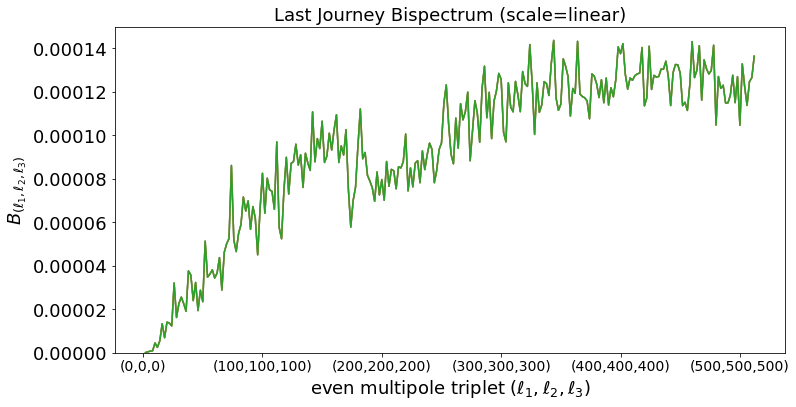

In [39]:
plot_bispec(Bls, xscale='linear', yscale='linear', ylim=[0, 0.00015], title="Last Journey Bispectrum (scale=linear)")

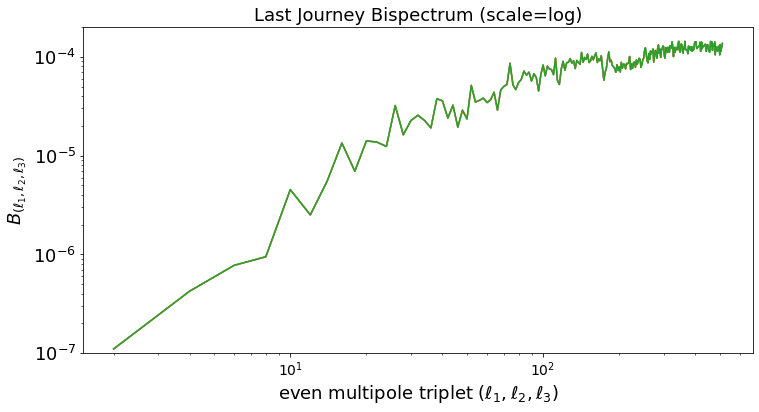

In [40]:
plot_bispec(Bls, ylim=[1e-7, 2e-4], title="Last Journey Bispectrum (scale=log)")